<a href="https://colab.research.google.com/github/mashdas/time_series/blob/master/sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time,series,format="-",start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)
  

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-05-28 19:44:08--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-05-28 19:44:08 (79.7 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [0]:
import csv
sunspots,time_stamp=[],[]
with open("/tmp/sunspots.csv") as csv_file:
  reader=csv.reader(csv_file,delimiter=",")
  next(reader)##Skips the first row
  for x in reader:
    sunspots.append(float(x[2]))
    time_stamp.append(float(x[0]))

series=np.array(sunspots)
time=np.array(time_stamp)    




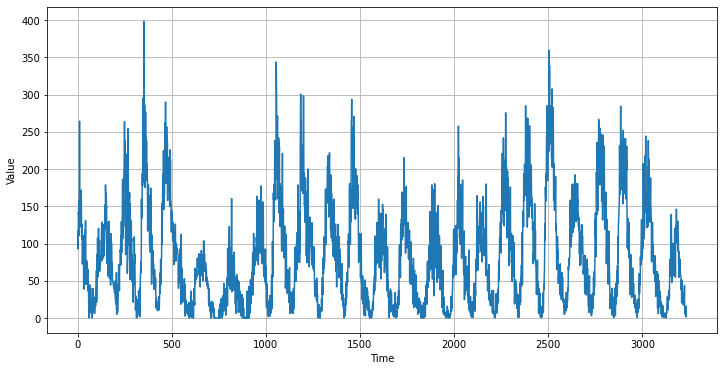

In [33]:
##The time series
plt.figure(figsize=(12,6))
plot_series(time,series)

In [35]:
series.shape

(3235,)

In [0]:
series=tf.expand_dims(series,axis=-1)

In [37]:
series.shape

TensorShape([3235, 1])

In [46]:
a=0
for x in series:
  print(x)
  a+=1
  if a==3:
    break

tf.Tensor([96.7], shape=(1,), dtype=float64)
tf.Tensor([104.3], shape=(1,), dtype=float64)
tf.Tensor([116.7], shape=(1,), dtype=float64)


In [0]:
ds=tf.data.Dataset.from_tensor_slices(series)

In [58]:
ds

<WindowDataset shapes: DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>

In [55]:
|##batch_size,window,dimensionality
x=np.array([[[1],[2],[3],[4]],[[1],[2],[3],[4]],[[1],[2],[3],[4]]])
x.shape

# def transform(series,window_size,batch_size,shuffle_buffer_size):
#   series=tf.expand_dims(series,axis=-1)


(3, 4, 1)

In [0]:
##Preprocessing
def transform(series,window_size,batch_size,shuffle_buffer):
  series=tf.expand_dims(series,axis=-1)
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda x: x.batch(window_size+1))
  dataset=dataset.shuffle(shuffle_buffer).map(lambda x:(x[:-1],x[-1]))
  dataset=dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
split_time,batch_size,window_size,shuffle_buffer_size=3000,256,64,1000

In [0]:
x_train=series[:split_time]
time_train=time[:split_time]
x_validation=series[split_time:]
time_validation=time[split_time:]

In [0]:
import tensorflow as tf

In [62]:
tf.keras.backend.clear_session()
tf.random.set_seed(1)
np.random.seed(1)
train_set=transform(x_train,window_size,batch_size,shuffle_buffer_size)


<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Conv1D,Lambda


In [66]:
model=Sequential()
model.add(Conv1D(32,5,strides=1,padding="causal",activation="relu",input_shape=[None,1]))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(64,return_sequences=True))
model.add(Dense(30,activation="relu"))
model.add(Dense(10,activation="relu"))
model.add(Dense(1))
model.add(Lambda(lambda x:x*400))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [0]:
##Lr scheduler
lr_schedule=tf.keras.callbacks.LearningRateScheduler(
    lambda x:1e-8*10**(x/20)
)
optimizer=tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])

In [0]:
history=model.fit(train_set,epochs=100,callbacks=[lr_schedule])

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
##Find the optimal lr and retrain the model for 500 epochs

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()